# **Denoising Dirty Documents using an Autoencoder**

El denoising (eliminación de ruido) es un proceso que busca recuperar la información original de una imagen que ha sido degradada por diferentes tipos de ruido o imperfecciones. En el contexto de documentos, el ruido puede manifestarse como manchas de tinta o suciedad, distorciones o imperfecciones visuales. En otras palabras, el objetivo del denoising es mejorar la legibilidad y calidad de estos documentos. 

Para este proyecto se utilizó un conjunto de datos obtenido de [Kaggle](https://www.kaggle.com/datasets/divyasuravaram/denoise) que contiene tres carpetas con imágenes de documentos:
* ***train:*** Documentos con ruido que serán las entradas del autoencoder.
* ***train_cleaned:*** Documentos sin ruido (limpios) que serán las salidas del autoencoder.
* ***test:*** Documentos con ruido para el conjunto de prueba. 

Para lograr esta tarea se empleará un autoencoder, que es un modelo de aprendizaje profundo no supervisado, cuyo objetivo principal es aprender una representación comprimida y eficiente de los datos de entrada. Está compuesto por dos partes fundamentales:
* **Encoder (Codificador):** Una red neuronal que transforma los datos de entrada en una representación latente de menor dimensionalidad. Esta etapa captura las características más importantes de los datos, eliminando información redundante o irrelevante.
* **Decoder (Decodificador):** Otra red neuronal que intenta reconstruir los datos originales a partir de la representación latente, minimizando el error entre la entrada y la salida reconstruida.

## Importar las librerías

In [1]:
#Operaciones numéricas y manejo de arrays
import numpy as np

#Visualización de imágenes y gráficos
import matplotlib.pyplot as plt

#Componentes de Keras para construir el modelo
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

#Métricas para evaluar la calidad de la reconstrucción
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

#Funciones auxiliares personalizadas para carga y visualización de imágenes
from tools import load_images, plot_image_pairs_comparison, plot_noisy_clean_reconstructed

## Cargar las imágenes

In [2]:
#Dimensiones para redimensionar las imágenes
width = 400
height = 400

#Cargar las imágenes de entrenamiento (con ruido y limpias) y de prueba
noisy = load_images('images/train/', width, height)
clean = load_images('images/train_cleaned/', width, height)
test = load_images('images/test/', width, height)

In [3]:
print('Shape of noisy:', noisy.shape)
print('Shape of clean:', clean.shape)
print('Shape of test:', test.shape)

Shape of noisy: (144, 400, 400, 1)
Shape of clean: (144, 400, 400, 1)
Shape of test: (72, 400, 400, 1)


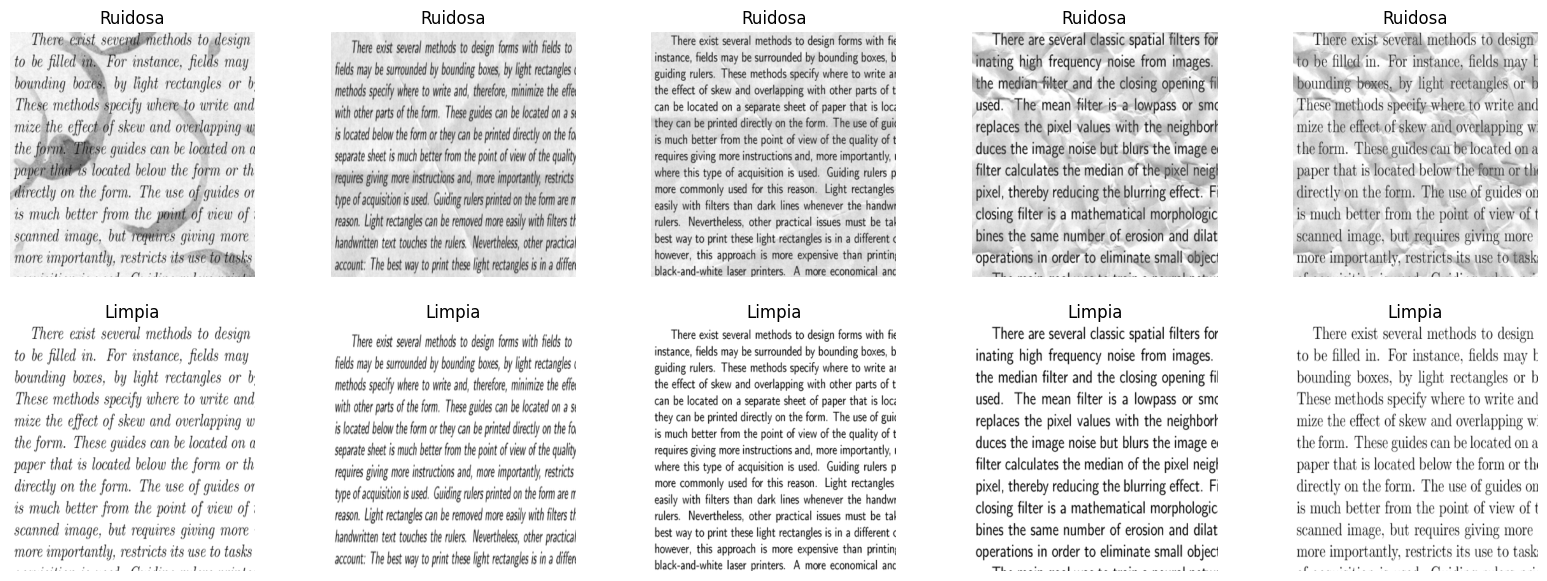

In [4]:
#Gráfica para mostrar ejemplos de las imágenes de entrenamiento
plot_image_pairs_comparison(noisy, clean, titles=('Ruidosa', 'Limpia'), height=height, width=width)

## Construir el autoencoder

Para imágenes, los autoencoders convolucionales son más efectivos que los densamente conectados, por ello se empleará un autoencoder con capas convolucionales para este proyecto.

In [5]:
#Capa de entrada con dimensiones de las imágenes
input = Input(shape=(height, width, 1)) 

#Encoder: Reduce la dimensionalidad aprendiendo características
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input) #Capa convolucional
x = MaxPooling2D((2, 2))(x) #Reducción de dimensionalidad

#Decoder: Reconstruye la imagen a partir de las características aprendidas
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) #Capa convolucional
x = UpSampling2D((2, 2))(x) #Aumento de dimensionalidad

#Capa de salida con activación sigmoid para valores entre 0 y 1
output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

#Creación del modelo autoencoder que mapea entrada a salida
autoencoder = Model(input, output)

#Compilación del modelo empleando el optimizador Adam y el MSE como función de pérdida
autoencoder.compile(optimizer='adam', loss='mse')

In [6]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400, 400, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 400, 400, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 200, 200, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 400, 400, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 400, 400, 1)    │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,017 (586.00 KB)

 Trainable params: 150,017 (586.00 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenar modelo

El modelo recibe como entrada imágenes con ruido y genera como salida imágenes limpias, ya que el objetivo es que el autoencoder aprenda a transformar imágenes ruidosas en versiones sin ruido.

In [7]:
history = autoencoder.fit(noisy, clean, epochs=45, batch_size=10, validation_split=0.01)

Epoch 1/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - loss: 0.1022 - val_loss: 0.0805
Epoch 2/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 0.0592 - val_loss: 0.0570
Epoch 3/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 0.0405 - val_loss: 0.0328
Epoch 4/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - loss: 0.0243 - val_loss: 0.0187
Epoch 5/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - loss: 0.0160 - val_loss: 0.0123
Epoch 6/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - loss: 0.0113 - val_loss: 0.0101
Epoch 7/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - loss: 0.0091 - val_loss: 0.0089
Epoch 8/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 0.0079 - val_loss: 0.0068
Epoch 9/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - loss: 0.0069 - val_loss: 0.0060
Epoch 10/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - loss: 0.0065 - val_loss: 0.0051
Epoch 11/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 0.0062 - val_loss: 0.0047
Epoch 12/45
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - loss: 0.0056 - val_lo

## Pérdida en el entrenamiento

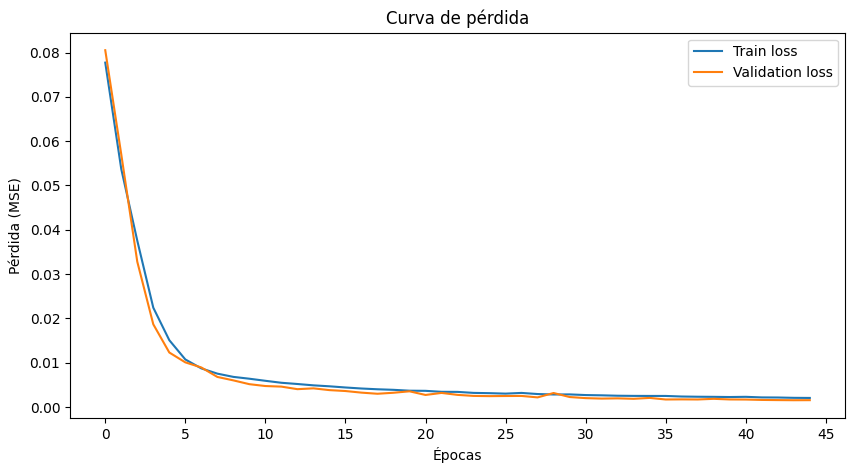

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.xticks(range(0, 46, 5))
plt.legend()
plt.title('Curva de pérdida')
plt.show()

## Histograma de errores por pixel

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


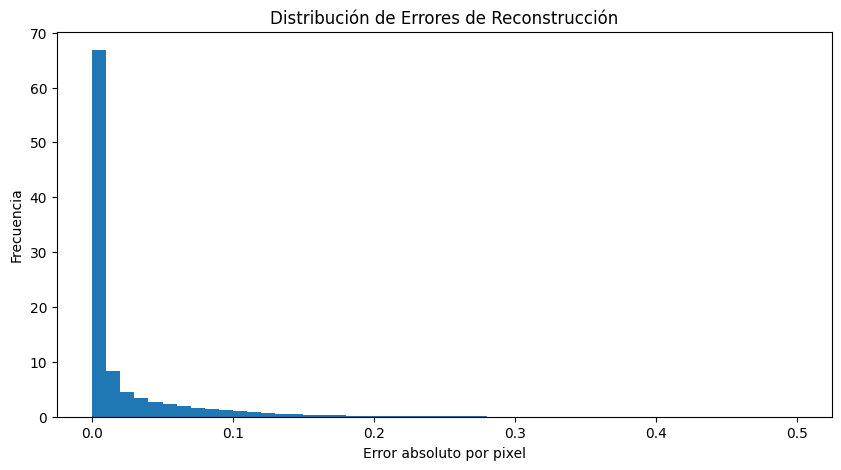

In [9]:
errors = np.abs(clean - autoencoder.predict(noisy)).flatten()
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, range=(0, 0.5), density=True)
plt.title('Distribución de Errores de Reconstrucción')
plt.xlabel('Error absoluto por pixel')
plt.ylabel('Frecuencia')
plt.show()

Se puede observar que la mayoría de los errores absolutos por píxel están muy cerca de cero, lo que indica que el autoencoder reconstruyó correctamente la mayoría de los píxeles. Es decir, el modelo está haciendo un buen trabajo eliminando el ruido.

Aunque existen discrepancias en algunos píxeles (posiblemente en bordes de caracteres o zonas con ruido complejo), estos casos son menos frecuentes y no invalidan el buen desempeño global del modelo.

## Imágenes ruidosas, limpias y reconstruidas en el conjunto de entrenamiento

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


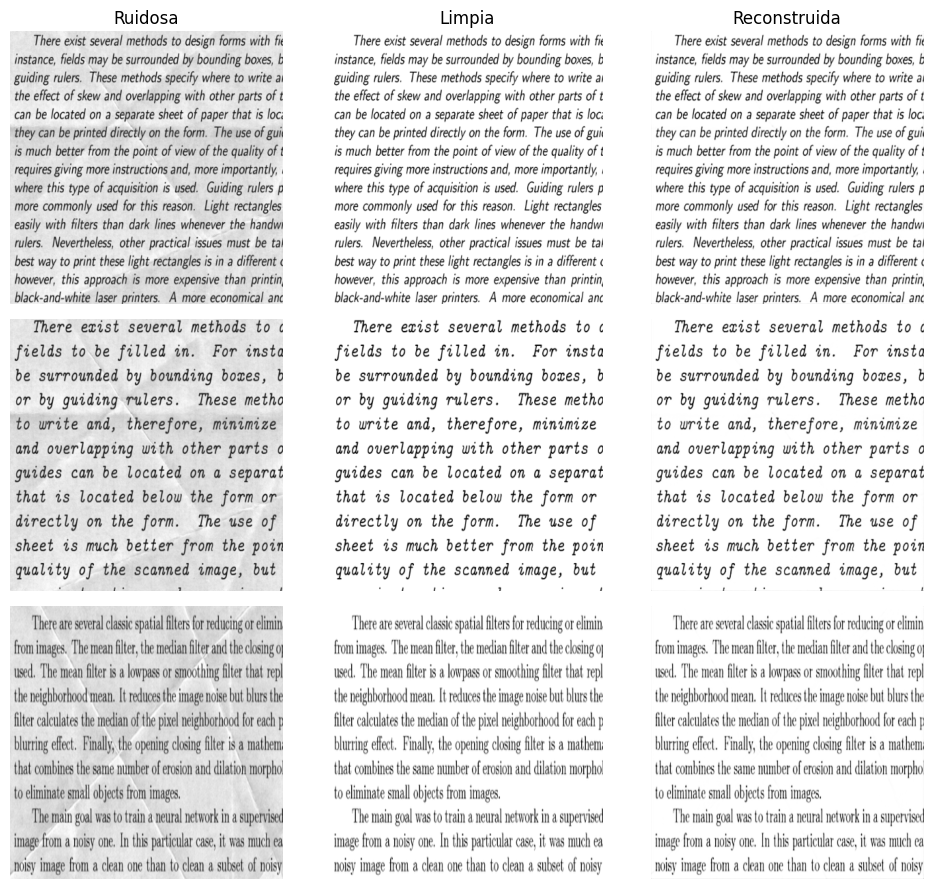

In [10]:
plot_noisy_clean_reconstructed(noisy, clean, autoencoder, num_images=3)

Con la imagen anterior, podemos notar que el autoencoder durante el entrenamiento rescontruyó bien las imágenes, pueden percibirse algunas incosistencias, pero estas son mínimas.

## Evaluar el modelo utilizando el conjunto de prueba

In [11]:
reconstructed = autoencoder.predict(test) #Imágenes reconstruidas a partir de las imágenes de test

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


##### **Métricas de evaluación**
* **Mean Squared Error (MSE):** Se utiliza para medir la diferencia entre los valores originales y los reconstruidos por el autoencoder. Cuanto menor sea el MSE, mejor será la reconstrucción.

* **Peak Signal-to-Noise Ratio (PSNR):** Se utiliza para medir la calidad de la reconstrucción de una imagen en términos de la relación entre la señal (información relevante) y el ruido (errores de reconstrucción). Se calcula a partir del MSE. Tiene unidades en decibelios (dB) y cuanto mayor sea el valor de PSNR, mejor será la calidad de la imagen reconstruida en relación con la original. 

* **Structural Similarity Index (SSIM):** Mide la similitud estructural entre la imagen original y la reconstruida. A diferencia del MSE, que solo se enfoca en la diferencia de intensidad de píxeles, el **SSIM** tiene en cuenta características más complejas como la luminancia, el contraste y la estructura de la imagen. Su valor varía entre -1 y 1, donde *1* indica una *reconstrucción idéntica a la imagen original*, y valores cercanos a *0* o negativos indican *diferencias significativas*. El **SSIM promedio** es simplemente el SSIM calculado para un conjunto de imágenes y luego promediado, proporcionando una medida general de la calidad visual del modelo.

In [12]:
mse = autoencoder.evaluate(test, test)

psnr_value = psnr(test, reconstructed, data_range=1)

ssim_values = []
for i in range(len(test)):
    ssim_value = ssim(test[i].squeeze(), reconstructed[i].squeeze(), data_range=1)
    ssim_values.append(ssim_value)
ssim_avg = np.mean(ssim_values)

print(f'MSE: {mse}')
print(f'PSNR: {psnr_value} dB')
print(f'SSIM promedio: {ssim_avg}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0360
MSE: 0.03580126911401749
PSNR: 14.461015431169749 dB
SSIM promedio: 0.8263548309818965


El valor del MSE es bajo, lo que indica que el autoencoder logró una reconstrucción numéricamente precisa de las imágenes, sugiriendo un desempeño satisfactorio en términos de error cuadrático medio.

En general, un valor de PSNR superior a 20 dB se considera indicativo de una buena calidad de reconstrucción. En este caso, el modelo alcanzó un PSNR de 14.46 dB, lo que sugiere que, aunque logra reducir la mayor parte del ruido, no recupera con precisión ciertos detalles finos, como bordes definidos o texturas.

El valor promedio de SSIM, indica que el modelo conserva de manera adecuada la estructura global del documento. No obstante, también sugiere ciertas limitaciones en la reconstrucción de detalles locales más delicados, como zonas con ruido complejo.

## Imágenes reconstruidas en el conjunto de prueba

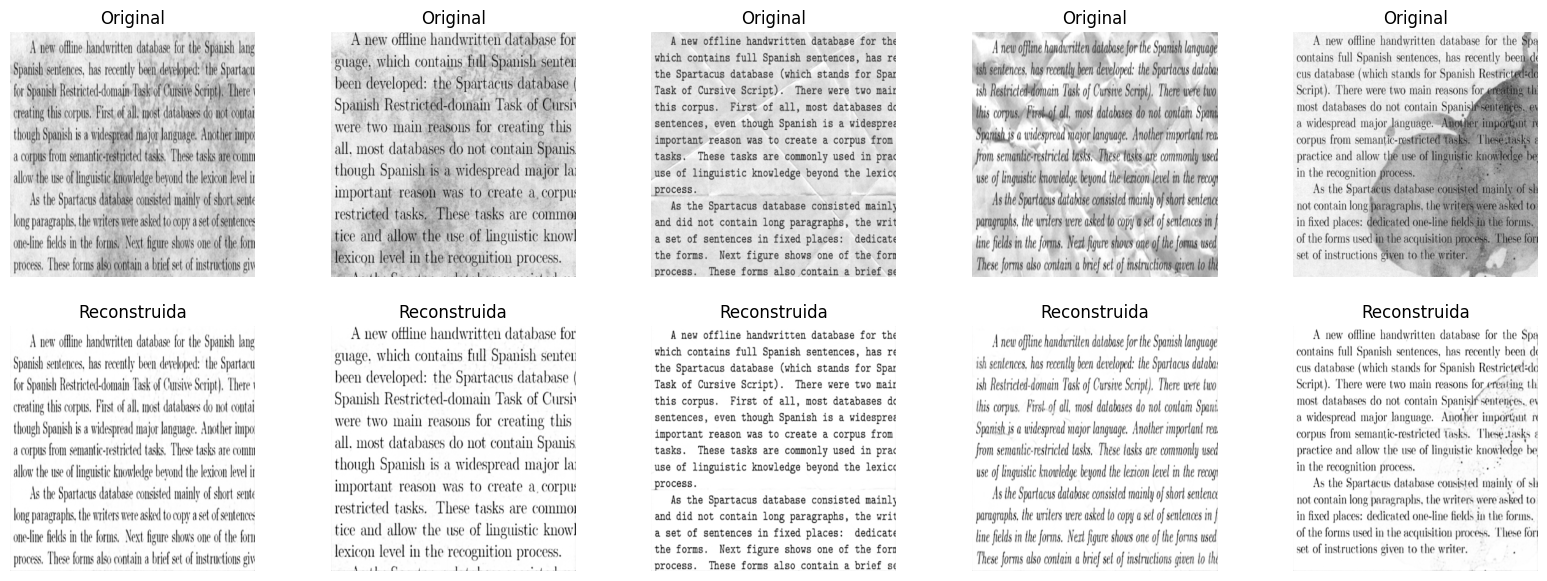

In [13]:
plot_image_pairs_comparison(test, reconstructed, titles=('Original', 'Reconstruida'), height=height, width=width)

Podemos observar que aunque algunas imágenes reconstruidas presentan pequeñas manchas, estas son mínimas y no comprometen la legibilidad del contenido. Los resultados demuestran que, incluso con una arquitectura sencilla, el autoencoder logra efectivamente reducir el ruido en los documentos y preservar con fidelidad la información textual.

Esto sugiere que el enfoque adoptado es adecuado para aplicaciones prácticas donde la prioridad es mantener la integridad del texto original.

## Guardar el modelo

In [14]:
autoencoder.save('document_denoising_autoencoder.h5')